In [1]:
%autoreload 2


In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


98 6272 64.0 100352 1024.0


In [4]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,1.00,...,0.975856,0.984382,0.970248,0.981414,0.981920,0.983617,0.919078,0.915602,0.974574,0.987096
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,1.00,...,0.985632,0.986181,0.966645,0.978594,0.977472,0.984273,0.921563,0.931860,0.945369,0.962067
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,0.00,...,0.975984,0.980604,0.000000,0.000000,0.000000,0.000000,0.844787,0.858832,0.923039,0.942307
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,0.00,...,0.986042,0.985931,0.000000,0.000000,0.000000,0.000000,0.919078,0.915602,0.974574,0.987096
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0.25,...,0.984624,0.983172,0.000000,0.000000,0.000000,0.000000,0.976741,0.978090,0.970715,0.987147


In [5]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df
from latest_model_paths import LATEST_FITNESS_FUNCTION_DATE_ID
model_date_id = LATEST_FITNESS_FUNCTION_DATE_ID
data_df = fitness_df
cv_energy_model, feature_columns = utils.load_model_and_feature_columns(model_date_id)
print(len(feature_columns))



331


In [6]:
from collections import Counter
counter = Counter([c[:c.index('arg_types') - 1] for c in data_df.columns if 'arg_types' in c])
print(', '.join(f'{k}: {v}' for k, v in counter.items()))

adjacent: 19, adjacent_side_3: 4, agent_holds: 11, between: 2, distance: 26, in: 17, in_motion: 11, object_orientation: 6, on: 34, touch: 16


In [7]:
[c for c in data_df.columns if 'logical' in c]

['nested_logicals_found',
 'identical_logical_children_found',
 'tautological_expression_found']

## Histogram the weights to get a sense of what we're dealing with

2023-04-18 21:05:15 DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-04-18 21:05:15 DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-04-18 21:05:15 DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-04-18 21:05:15 DEBUG    findfont: score(FontEntry(fname='/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-04-18 21:05:15 DEBUG    findfont: score(FontEntry(fname='/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-04-18 21:05:15 DEBUG    findfont: score(FontEntry(fname='/Users/guy

Weights mean: 0.1186, std: 2.3959, bias: 0.0100


2023-04-18 21:05:15 DEBUG    findfont: score(FontEntry(fname='/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-04-18 21:05:15 DEBUG    findfont: score(FontEntry(fname='/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
2023-04-18 21:05:15 DEBUG    findfont: score(FontEntry(fname='/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2023-04-18 21:05:15 DEBUG    findfont: score(FontEntry(fname='/Users/guydavidson/opt/ana

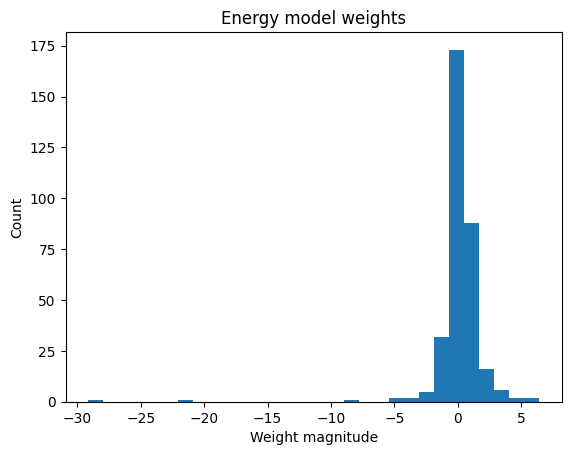

In [8]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=30)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [9]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantile_index = 0

abs_weights = weights.abs()

for magnitude in torch.linspace(0,abs_weights.max(), 5000):
    n = torch.sum(abs_weights < magnitude).item()
    if n / len(weights) >= quantiles[quantile_index]:
        print(f'Approximately {quantiles[quantile_index] * 100}% ({n}, {n / len(weights) * 100:.2f}%) of the weights have magnitude < {magnitude:.4f}')
        quantile_index += 1

    if quantile_index >= len(quantiles):
        break

Approximately 10.0% (35, 10.57%) of the weights have magnitude < 0.0641
Approximately 25.0% (84, 25.38%) of the weights have magnitude < 0.2157
Approximately 50.0% (166, 50.15%) of the weights have magnitude < 0.5423
Approximately 75.0% (249, 75.23%) of the weights have magnitude < 1.0029
Approximately 90.0% (298, 90.03%) of the weights have magnitude < 2.0291
Approximately 95.0% (315, 95.17%) of the weights have magnitude < 3.1311
Approximately 99.0% (328, 99.09%) of the weights have magnitude < 6.4139


## Print the top K features most and least predictive of real games

In [10]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games):')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games):')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games):
1. ast_ngram_full_n_7_score (-29.1480)
2. ast_ngram_constraints_n_7_score (-21.3882)
3. ast_ngram_setup_n_5_score (-8.6212)
4. all_variables_used (-5.1214)
5. all_preferences_used (-4.5855)
6. ast_ngram_scoring_n_5_score (-3.8008)
7. ast_ngram_terminal_n_5_score (-3.1279)
8. all_variables_defined (-2.1562)
9. in_motion_arg_types_small_objects_constraints (-2.0817)
10. mean_depth_setup_0 (-2.0254)
11. max_depth_setup_0 (-1.9558)
12. setup_quantified_objects_used (-1.9107)
13. node_count_setup_0 (-1.8478)
14. section_doesnt_exist_setup (-1.8369)
15. on_arg_types_furniture_large_objects_constraints (-1.7814)
16. pref_forall_pref_forall_correct_arity_correct (-1.5324)
17. in_arg_types_any_object_any_object_constraints (-1.4752)
18. predicate_under_modal_once_adjacent (-1.3316)
19. distance_arg_types_balls_balls_setup (-1.3221)
20. setup_objects_used (-1.3050)
### Features with largest positive weights (most predictive of fake games):
1. pref_forall_pref_forall_correct_types_incorrect (6.4081)
2. pref_forall_used_incorrect (6.1360)
3. repeated_variables_found (4.9560)
4. two_number_operation_found (4.2762)
5. disjoint_seq_funcs_found (3.9823)
6. in_arg_types_other_constraints (3.6979)
7. pref_forall_pref_forall_correct_arity_incorrect (3.4196)
8. redundant_expression_found (3.4028)
9. distance_arg_types_other_constraints (3.3871)
10. adjacent_arg_types_other_constraints (3.2973)
11. in_motion_arg_types_other_setup (2.8316)
12. distance_arg_types_furniture_receptacles_setup (2.7956)
13. in_motion_arg_types_room_features_constraints (2.7909)
14. agent_holds_arg_types_other_setup (2.7193)
15. in_motion_arg_types_agent_constraints (2.6423)
16. agent_holds_arg_types_room_features_constraints (2.5925)
17. on_arg_types_furniture_small_objects_constraints (2.4996)
18. agent_holds_arg_types_agent_constraints (2.4738)
19. adjacent_arg_types_room_features_room_features_constraints (2.4535)
20. nested_logicals_found (2.4057)

In [11]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'logical' in c]

[('nested_logicals_found', tensor(2.4057)),
 ('identical_logical_children_found', tensor(1.1730)),
 ('tautological_expression_found', tensor(1.1384))]

In [12]:
data_df.groupby('real').distance_arg_types_furniture_receptacles_setup.describe()

,count,mean,std,min,25%,50%,75%,max
real,,,,,,,,
0,100352.0,0.011779,0.107888,0.0,0.0,0.0,0.0,1.0
1,98.0,0.010204,0.101015,0.0,0.0,0.0,0.0,1.0


In [13]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'disjoint_seq_funcs_found' in c]

[('disjoint_seq_funcs_found', tensor(3.9823))]

In [14]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if c.startswith('ast_ngram') and c.endswith('score')]

[('ast_ngram_full_n_7_score', tensor(-29.1480)),
 ('ast_ngram_setup_n_5_score', tensor(-8.6212)),
 ('ast_ngram_constraints_n_7_score', tensor(-21.3882)),
 ('ast_ngram_terminal_n_5_score', tensor(-3.1279)),
 ('ast_ngram_scoring_n_5_score', tensor(-3.8008))]

## Plot a histogram of the values for each of the and bottom K features

In [15]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        ax = axes[i // layout[1]][i % layout[1]]

        real_values = df[df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = df[df.real == 0][feature_columns[feature_index]].to_numpy()

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Feature value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title_feature = f'#{i + 1}: {feature_columns[feature_index]}'
        title_weight = f'(weight: {top_k.values[i]:.4f})'
        if len(title_feature) > title_split_threshold:
            title_split_index = title_feature.find('_', title_split_threshold) + 1
            if title_split_index == 0:
                title_split_index = len(title_feature)
            title = f'{title_feature[:title_split_index]}\n{title_feature[title_split_index:]} {title_weight}'
        else:
            title = f'{title_feature}\n{title_weight}'

        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

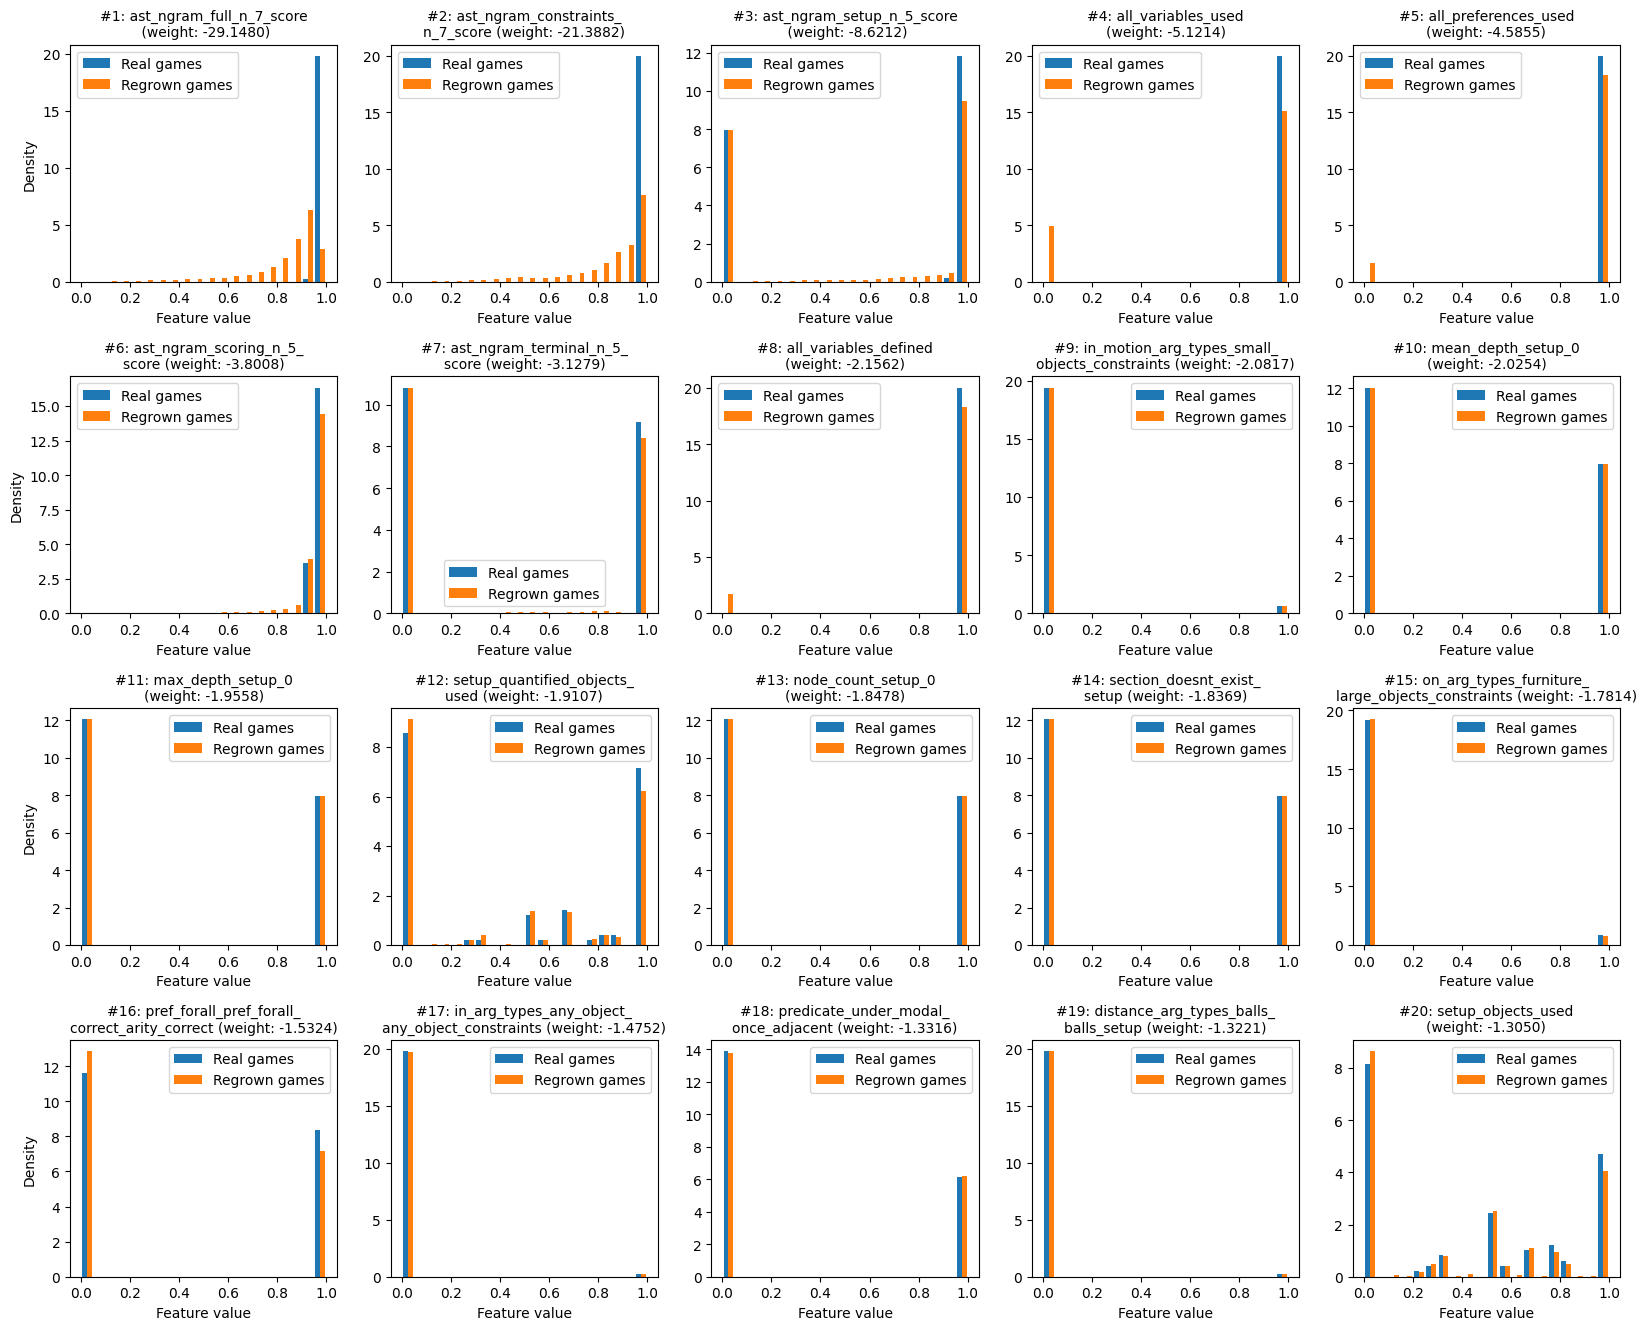

In [16]:
k = 20
plot_value_histograms(data_df, weights, k=k, largest=False, bins=20, histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## For the 20 features with largest weights, that is, most predictive of a fake game

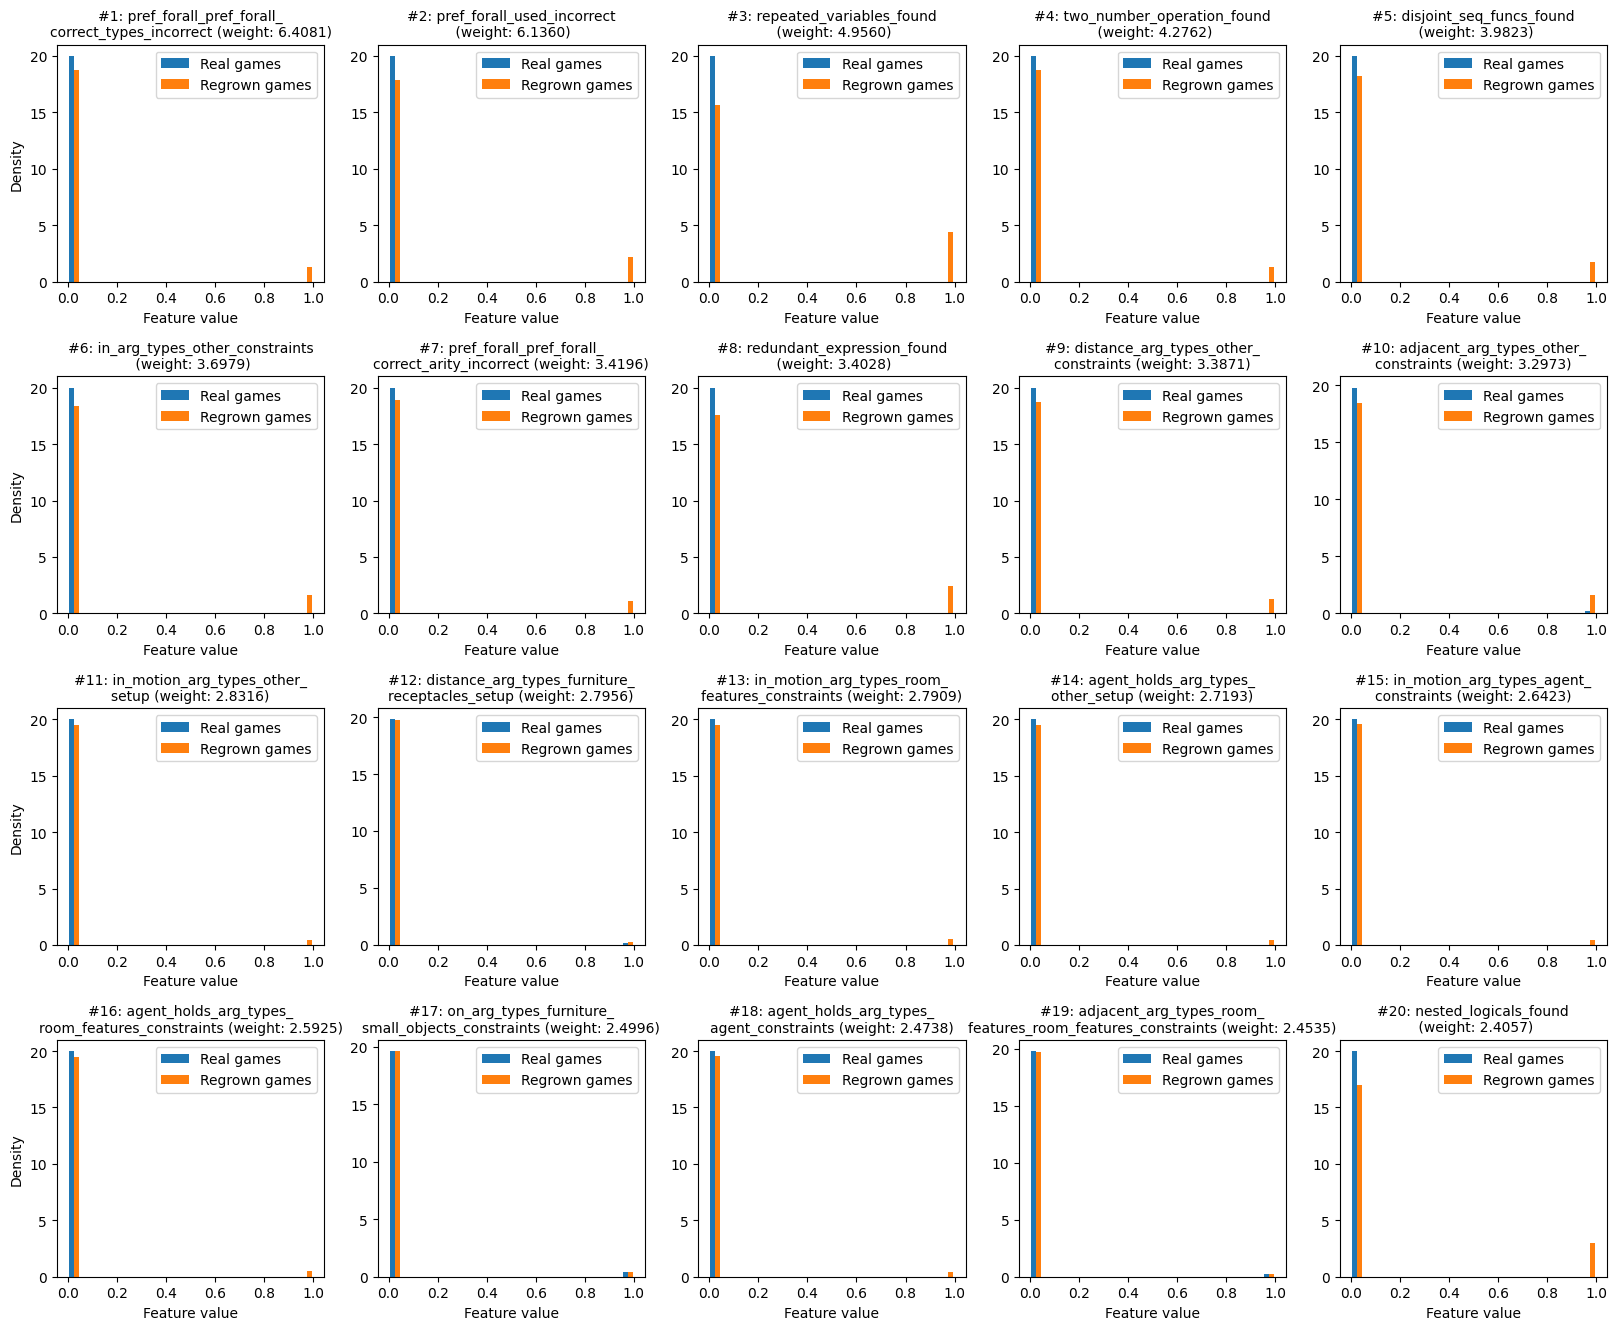

In [17]:
plot_value_histograms(data_df, weights, k=k, largest=True, bins=20,  histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## Visualizing some top negatives

In [18]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [19]:
real_game_scores = full_tensor_scores[:, 0]
print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

Real game scores: -76.6105 ± 0.9659, min = -80.0098, max = -74.9304


In [ ]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [20]:
negatives_scores = full_tensor_scores[:, 1:]

In [21]:
positive_scores = full_tensor_scores[:, 0]
score_diffs = negatives_scores - positive_scores.unsqueeze(1)

In [22]:
torch.topk(score_diffs.ravel(), 10, largest=False)

torch.return_types.topk(
values=tensor([-1.3035, -1.3035, -1.3035, -1.2376, -1.0477, -1.0477, -1.0477, -0.9987,
        -0.9987, -0.9987]),
indices=tensor([15366, 15783, 77101, 53544, 69611, 69223, 68686, 96327, 97016, 96859]))

In [23]:
N_NEGATIVES = 20
for index in torch.topk(score_diffs.ravel(), N_NEGATIVES, largest=False).indices:
    utils.evaluate_energy_contributions(cv_energy_model, full_tensor, index, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False, min_display_threshold=0.001)
    
    display(Markdown('---'))

Original game index: 15 | Negative game row: 15 | Negative game col: 423


### Energy of real game: -75.267 | Energy of regrown game: -76.570 | Difference: -1.304

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                                                 |
|--------------------------------------------|------------------------------------------------------------------------------------------|
|                                            | distance_arg_types_agent_receptacles_constraints: **-1.304** = (0.000 => 1.000) * -1.304 |

### Game Diffs

n,1,(define (game 60e93f64ec69ecdac3107555-19) (:domain medium-objects-room-v1),n,1,(define (game 60e93f64ec69ecdac3107555-19-423-nd-22-rd-1-rs-constraints-sk-prior
,,,,>,5) (:domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?b - ball),,4,(forall (?b - ball)
,5,(game-optional,,5,(game-optional
,6,(< (distance door ?b) 1),,6,(< (distance door ?b) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)


---

Original game index: 15 | Negative game row: 15 | Negative game col: 6


### Energy of real game: -75.267 | Energy of regrown game: -76.570 | Difference: -1.304

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                                                 |
|--------------------------------------------|------------------------------------------------------------------------------------------|
|                                            | distance_arg_types_agent_receptacles_constraints: **-1.304** = (0.000 => 1.000) * -1.304 |

### Game Diffs

n,1,(define (game 60e93f64ec69ecdac3107555-19) (:domain medium-objects-room-v1),n,1,(define (game 60e93f64ec69ecdac3107555-19-6-nd-23-rd-1-rs-constraints-sk-prior5)
,,,,>,(:domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?b - ball),,4,(forall (?b - ball)
,5,(game-optional,,5,(game-optional
,6,(< (distance door ?b) 1),,6,(< (distance door ?b) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)


---

Original game index: 75 | Negative game row: 75 | Negative game col: 301


### Energy of real game: -75.372 | Energy of regrown game: -76.675 | Difference: -1.303

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                                                 |
|--------------------------------------------|------------------------------------------------------------------------------------------|
|                                            | distance_arg_types_agent_receptacles_constraints: **-1.304** = (0.000 => 1.000) * -1.304 |

### Game Diffs

n,1,(define (game 5fefd5b2173bfbe890bc98ed-88) (:domain few-objects-room-v1),n,1,(define (game 5fefd5b2173bfbe890bc98ed-88-301-nd-21-rd-1-rs-constraints-sk-prior
,,,,>,5) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin ?p - pillow ?b1 ?b2 ?b3 ?b4 ?b5 ?b6 - cube_block,,4,(exists (?h - hexagonal_bin ?p - pillow ?b1 ?b2 ?b3 ?b4 ?b5 ?b6 - cube_block
,>,),,>,)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
,7,(on bed ?h),,7,(on bed ?h)
,8,(object_orientation ?p diagonal),,8,(object_orientation ?p diagonal)
,9,(adjacent_side ?h left ?b1),,9,(adjacent_side ?h left ?b1)


---

Original game index: 52 | Negative game row: 52 | Negative game col: 296


### Energy of real game: -76.520 | Energy of regrown game: -77.758 | Difference: -1.238

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                                | Features decreasing energy (= more real)                                               |
|-----------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| on_arg_types_furniture_large_objects_constraints: **1.781** = (1.000 => 0.000) * -1.781 | in_motion_arg_types_receptacles_constraints: **-1.245** = (1.000 => 0.000) * 1.245     |
| in_motion_arg_types_large_objects_constraints: **0.197** = (1.000 => 0.000) * -0.197    | agent_holds_arg_types_receptacles_constraints: **-1.092** = (1.000 => 0.000) * 1.092   |
| ast_ngram_full_n_7_score: **0.157** = (0.977 => 0.971) * -29.148                        | on_arg_types_furniture_receptacles_constraints: **-0.818** = (1.000 => 0.000) * 0.818  |
| ast_ngram_constraints_n_7_score: **0.098** = (0.987 => 0.982) * -21.388                 | agent_holds_arg_types_large_objects_constraints: **-0.316** = (1.000 => 0.000) * 0.316 |

### Game Diffs

n,1,(define (game 601c84e07ab4907ded068d0d-62) (:domain medium-objects-room-v1),n,1,(define (game 601c84e07ab4907ded068d0d-62-296-nd-11-rd-3-rs-constraints-sk-prior
,,,,>,5) (:domain medium-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bigObjectThrownToBed,,4,(preference bigObjectThrownToBed
t,5,(exists (?o - (either chair laptop doggie_bed)),t,5,(exists (?o - game_object)
,6,(then,,6,(then
,7,(once (and (agent_holds ?o) (adjacent desk agent) ) ),,7,(once (and (agent_holds ?o) (adjacent desk agent) ) )
,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) ),,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) )
,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) ),,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) )
,10,),,10,)


---

Original game index: 67 | Negative game row: 67 | Negative game col: 1003


### Energy of real game: -75.549 | Energy of regrown game: -76.596 | Difference: -1.048

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                                 | Features decreasing energy (= more real)                                              |
|------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| distance_arg_types_receptacles_room_features_setup: **1.174** = (0.000 => 1.000) * 1.174 | distance_arg_types_furniture_receptacles_setup: **-2.796** = (1.000 => 0.000) * 2.796 |
| distance_arg_types_balls_furniture_setup: **0.414** = (1.000 => 0.000) * -0.414          |                                                                                       |
| distance_arg_types_balls_room_features_setup: **0.159** = (0.000 => 1.000) * 0.159       |                                                                                       |

### Game Diffs

n,1,(define (game 5eeb326764eb142830aa5cfb-78) (:domain medium-objects-room-v1),n,1,(define (game 5eeb326764eb142830aa5cfb-78-1003-nd-12-rd-5-rs-setup-sk-prior5) (:
,,,,>,domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(adjacent_side bed front_left_corner ?t),,7,(adjacent_side bed front_left_corner ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 67 | Negative game row: 67 | Negative game col: 615


### Energy of real game: -75.549 | Energy of regrown game: -76.596 | Difference: -1.048

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                                 | Features decreasing energy (= more real)                                              |
|------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| distance_arg_types_receptacles_room_features_setup: **1.174** = (0.000 => 1.000) * 1.174 | distance_arg_types_furniture_receptacles_setup: **-2.796** = (1.000 => 0.000) * 2.796 |
| distance_arg_types_balls_furniture_setup: **0.414** = (1.000 => 0.000) * -0.414          |                                                                                       |
| distance_arg_types_balls_room_features_setup: **0.159** = (0.000 => 1.000) * 0.159       |                                                                                       |

### Game Diffs

n,1,(define (game 5eeb326764eb142830aa5cfb-78) (:domain medium-objects-room-v1),n,1,(define (game 5eeb326764eb142830aa5cfb-78-615-nd-15-rd-2-rs-setup-sk-prior5) (:d
,,,,>,omain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(adjacent_side bed front_left_corner ?t),,7,(adjacent_side bed front_left_corner ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 67 | Negative game row: 67 | Negative game col: 78


### Energy of real game: -75.549 | Energy of regrown game: -76.596 | Difference: -1.048

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                                 | Features decreasing energy (= more real)                                              |
|------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| distance_arg_types_receptacles_room_features_setup: **1.174** = (0.000 => 1.000) * 1.174 | distance_arg_types_furniture_receptacles_setup: **-2.796** = (1.000 => 0.000) * 2.796 |
| distance_arg_types_balls_furniture_setup: **0.414** = (1.000 => 0.000) * -0.414          |                                                                                       |
| distance_arg_types_balls_room_features_setup: **0.159** = (0.000 => 1.000) * 0.159       |                                                                                       |

### Game Diffs

n,1,(define (game 5eeb326764eb142830aa5cfb-78) (:domain medium-objects-room-v1),n,1,(define (game 5eeb326764eb142830aa5cfb-78-78-nd-16-rd-1-rs-setup-sk-prior5) (:do
,,,,>,main medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(adjacent_side bed front_left_corner ?t),,7,(adjacent_side bed front_left_corner ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 94 | Negative game row: 94 | Negative game col: 603


### Energy of real game: -76.350 | Energy of regrown game: -77.348 | Difference: -0.999

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                  | Features decreasing energy (= more real)                                                              |
|-----------------------------------------------------------|-------------------------------------------------------------------------------------------------------|
| setup_objects_used: **0.174** = (0.800 => 0.667) * -1.305 | adjacent_side_3_arg_types_other_setup: **-0.720** = (1.000 => 0.000) * 0.720                          |
|                                                           | adjacent_side_3_arg_types_furniture_sides_large_objects_setup: **-0.453** = (0.000 => 1.000) * -0.453 |

### Game Diffs

n,1,(define (game 5e606b1eaf84e83c728748d7-115) (:domain medium-objects-room-v1),n,1,(define (game 5e606b1eaf84e83c728748d7-115-603-nd-18-rd-2-rs-setup-sk-prior5) (:
,,,,>,domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?c - chair ?r - triangular_ramp ?t - teddy_bear ?h - hexagonal_bin),,4,(exists (?c - chair ?r - triangular_ramp ?t - teddy_bear ?h - hexagonal_bin)
,5,(and,,5,(and
,6,(game-conserved,,6,(game-conserved
,7,(and,,7,(and
,8,(< (distance room_center ?r) 0.5),,8,(< (distance room_center ?r) 0.5)
t,9,(adjacent_side ?r front ?c),t,9,(adjacent_side bed front ?c)
,10,(between ?h ?c ?r),,10,(between ?h ?c ?r)


---

Original game index: 94 | Negative game row: 94 | Negative game col: 71


### Energy of real game: -76.350 | Energy of regrown game: -77.348 | Difference: -0.999

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                  | Features decreasing energy (= more real)                                                              |
|-----------------------------------------------------------|-------------------------------------------------------------------------------------------------------|
| setup_objects_used: **0.174** = (0.800 => 0.667) * -1.305 | adjacent_side_3_arg_types_other_setup: **-0.720** = (1.000 => 0.000) * 0.720                          |
|                                                           | adjacent_side_3_arg_types_furniture_sides_large_objects_setup: **-0.453** = (0.000 => 1.000) * -0.453 |

### Game Diffs

n,1,(define (game 5e606b1eaf84e83c728748d7-115) (:domain medium-objects-room-v1),n,1,(define (game 5e606b1eaf84e83c728748d7-115-71-nd-19-rd-1-rs-setup-sk-prior5) (:d
,,,,>,omain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?c - chair ?r - triangular_ramp ?t - teddy_bear ?h - hexagonal_bin),,4,(exists (?c - chair ?r - triangular_ramp ?t - teddy_bear ?h - hexagonal_bin)
,5,(and,,5,(and
,6,(game-conserved,,6,(game-conserved
,7,(and,,7,(and
,8,(< (distance room_center ?r) 0.5),,8,(< (distance room_center ?r) 0.5)
t,9,(adjacent_side ?r front ?c),t,9,(adjacent_side desk front ?c)
,10,(between ?h ?c ?r),,10,(between ?h ?c ?r)


---

Original game index: 94 | Negative game row: 94 | Negative game col: 760


### Energy of real game: -76.350 | Energy of regrown game: -77.348 | Difference: -0.999

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                  | Features decreasing energy (= more real)                                                              |
|-----------------------------------------------------------|-------------------------------------------------------------------------------------------------------|
| setup_objects_used: **0.174** = (0.800 => 0.667) * -1.305 | adjacent_side_3_arg_types_other_setup: **-0.720** = (1.000 => 0.000) * 0.720                          |
|                                                           | adjacent_side_3_arg_types_furniture_sides_large_objects_setup: **-0.453** = (0.000 => 1.000) * -0.453 |

### Game Diffs

n,1,(define (game 5e606b1eaf84e83c728748d7-115) (:domain medium-objects-room-v1),n,1,(define (game 5e606b1eaf84e83c728748d7-115-760-nd-18-rd-2-rs-setup-sk-prior5) (:
,,,,>,domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?c - chair ?r - triangular_ramp ?t - teddy_bear ?h - hexagonal_bin),,4,(exists (?c - chair ?r - triangular_ramp ?t - teddy_bear ?h - hexagonal_bin)
,5,(and,,5,(and
,6,(game-conserved,,6,(game-conserved
,7,(and,,7,(and
,8,(< (distance room_center ?r) 0.5),,8,(< (distance room_center ?r) 0.5)
t,9,(adjacent_side ?r front ?c),t,9,(adjacent_side side_table front_left_corner ?c)
,10,(between ?h ?c ?r),,10,(between ?h ?c ?r)


---

Original game index: 35 | Negative game row: 35 | Negative game col: 520


### Energy of real game: -75.611 | Energy of regrown game: -76.588 | Difference: -0.977

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                | Features decreasing energy (= more real)                                             |
|-------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| ast_ngram_full_n_7_score: **0.057** = (0.970 => 0.968) * -29.148        | agent_holds_arg_types_receptacles_constraints: **-1.092** = (1.000 => 0.000) * 1.092 |
| ast_ngram_constraints_n_7_score: **0.057** = (0.977 => 0.975) * -21.388 |                                                                                      |

### Game Diffs

n,1,(define (game 617378aeffbba11d8971051c-43) (:domain medium-objects-room-v1),n,1,(define (game 617378aeffbba11d8971051c-43-520-nd-23-rd-1-rs-constraints-sk-prior
,,,,>,5) (:domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?d - doggie_bed),,4,(exists (?d - doggie_bed)
,5,(game-conserved,,5,(game-conserved
,6,(< (distance room_center ?d) 1),,6,(< (distance room_center ?d) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)


---

Original game index: 41 | Negative game row: 41 | Negative game col: 857


### Energy of real game: -77.663 | Energy of regrown game: -78.494 | Difference: -0.831

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                         | Features decreasing energy (= more real)                                                  |
|----------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| distance_arg_types_balls_receptacles_setup: **0.343** = (0.000 => 1.000) * 0.343 | distance_arg_types_receptacles_room_features_setup: **-1.174** = (1.000 => 0.000) * 1.174 |

### Game Diffs

n,1,(define (game 5f3aee04e30eac7cb73b416e-50) (:domain medium-objects-room-v1),n,1,(define (game 5f3aee04e30eac7cb73b416e-50-857-nd-13-rd-4-rs-setup-sk-prior5) (:d
,,,,>,omain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
t,6,(< (distance room_center ?h) 1),t,6,(< (distance green_golfball ?h) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)


---

Original game index: 46 | Negative game row: 46 | Negative game col: 925


### Energy of real game: -77.304 | Energy of regrown game: -78.135 | Difference: -0.831

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                         | Features decreasing energy (= more real)                                                  |
|----------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| distance_arg_types_balls_receptacles_setup: **0.343** = (0.000 => 1.000) * 0.343 | distance_arg_types_receptacles_room_features_setup: **-1.174** = (1.000 => 0.000) * 1.174 |

### Game Diffs

n,1,(define (game 5f7654f879a4420e6d20971b-55) (:domain few-objects-room-v1),n,1,(define (game 5f7654f879a4420e6d20971b-55-925-nd-16-rd-1-rs-setup-sk-prior5) (:d
,,,,>,omain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
t,6,(< (distance room_center ?h) 1),t,6,(< (distance green_golfball ?h) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)


---

Original game index: 29 | Negative game row: 29 | Negative game col: 54


### Energy of real game: -76.053 | Energy of regrown game: -76.776 | Difference: -0.723

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                                                  |
|--------------------------------------------|-------------------------------------------------------------------------------------------|
|                                            | adjacent_arg_types_agent_room_features_constraints: **-0.723** = (1.000 => 0.000) * 0.723 |

### Game Diffs

n,1,(define (game 5fa45dc96da3af0b7dcba9a8-37) (:domain many-objects-room-v1),n,1,(define (game 5fa45dc96da3af0b7dcba9a8-37-54-nd-18-rd-1-rs-constraints-sk-prior5
,,,,>,) (:domain many-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference throwToBinFromOppositeWall,,4,(preference throwToBinFromOppositeWall
,5,(exists (?d - dodgeball ?h - hexagonal_bin ?w1 ?w2 - wall),,5,(exists (?d - dodgeball ?h - hexagonal_bin ?w1 ?w2 - wall)
,6,(then,,6,(then
t,7,(once (and (agent_holds ?d) (adjacent agent ?w1) (opposite ?w1 ?w2) (a,t,7,(once (and (agent_holds ?d) (adjacent ?h ?w1) (opposite ?w1 ?w2) (adja
,>,djacent ?h ?w2) ) ),,>,cent ?h ?w2) ) )
,8,(hold (and (not (agent_holds ?d) ) (in_motion ?d) ) ),,8,(hold (and (not (agent_holds ?d) ) (in_motion ?d) ) )
,9,(once (and (not (in_motion ?d) ) (in ?h ?d) ) ),,9,(once (and (not (in_motion ?d) ) (in ?h ?d) ) )


---

Original game index: 92 | Negative game row: 92 | Negative game col: 550


### Energy of real game: -75.891 | Energy of regrown game: -76.611 | Difference: -0.720

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                                     |
|--------------------------------------------|------------------------------------------------------------------------------|
|                                            | adjacent_side_3_arg_types_other_setup: **-0.720** = (1.000 => 0.000) * 0.720 |

### Game Diffs

n,1,(define (game 6005e777d1d8768d5808b5fd-113) (:domain few-objects-room-v1),n,1,(define (game 6005e777d1d8768d5808b5fd-113-550-nd-16-rd-1-rs-setup-sk-prior5) (:
,,,,>,domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin ?c1 ?c2 ?c3 ?c4 - cube_block ?r - curved_wooden_,,4,(exists (?h - hexagonal_bin ?c1 ?c2 ?c3 ?c4 - cube_block ?r - curved_wooden_
,>,ramp),,>,ramp)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
,7,(adjacent_side ?h front ?c1),,7,(adjacent_side ?h front ?c1)
,8,(adjacent ?c1 ?c3),,8,(adjacent ?c1 ?c3)
,9,(between ?h ?c1 ?c3),,9,(between ?h ?c1 ?c3)


---

Original game index: 9 | Negative game row: 9 | Negative game col: 181


### Energy of real game: -76.952 | Energy of regrown game: -77.648 | Difference: -0.695

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                         | Features decreasing energy (= more real)                                                  |
|----------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| adjacent_arg_types_agent_ramps_constraints: **0.028** = (0.000 => 1.000) * 0.028 | adjacent_arg_types_agent_room_features_constraints: **-0.723** = (1.000 => 0.000) * 0.723 |

### Game Diffs

n,1,(define (game 613bb29f16252362f4dc11a3-12) (:domain medium-objects-room-v1),n,1,(define (game 613bb29f16252362f4dc11a3-12-181-nd-18-rd-1-rs-constraints-sk-prior
,,,,>,5) (:domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(< (distance room_center ?h) 1),,6,(< (distance room_center ?h) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)


---

Original game index: 10 | Negative game row: 10 | Negative game col: 793


### Energy of real game: -76.652 | Energy of regrown game: -77.347 | Difference: -0.695

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                         | Features decreasing energy (= more real)                                                  |
|----------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| adjacent_arg_types_agent_ramps_constraints: **0.028** = (0.000 => 1.000) * 0.028 | adjacent_arg_types_agent_room_features_constraints: **-0.723** = (1.000 => 0.000) * 0.723 |

### Game Diffs

n,1,(define (game 616e5ae706e970fe0aff99b6-13) (:domain many-objects-room-v1),n,1,(define (game 616e5ae706e970fe0aff99b6-13-793-nd-20-rd-1-rs-constraints-sk-prior
,,,,>,5) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin ?r - triangular_ramp),,4,(exists (?h - hexagonal_bin ?r - triangular_ramp)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
,7,(< (distance ?h ?r) 1),,7,(< (distance ?h ?r) 1)
,8,(< (distance room_center ?r) 0.5),,8,(< (distance room_center ?r) 0.5)
,9,),,9,)
,10,),,10,)


---

Original game index: 67 | Negative game row: 67 | Negative game col: 537


### Energy of real game: -75.549 | Energy of regrown game: -76.244 | Difference: -0.695

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                              |
|--------------------------------------------|-----------------------------------------------------------------------|
|                                            | setup_quantified_objects_used: **-0.478** = (0.500 => 0.750) * -1.911 |
|                                            | setup_objects_used: **-0.218** = (0.333 => 0.500) * -1.305            |

### Game Diffs

n,1,(define (game 5eeb326764eb142830aa5cfb-78) (:domain medium-objects-room-v1),n,1,(define (game 5eeb326764eb142830aa5cfb-78-537-nd-11-rd-1-rs-constraints-sk-prior
,,,,>,5) (:domain medium-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(adjacent_side bed front_left_corner ?t),,7,(adjacent_side bed front_left_corner ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 86 | Negative game row: 86 | Negative game col: 740


### Energy of real game: -76.756 | Energy of regrown game: -77.408 | Difference: -0.653

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                   |
|--------------------------------------------|------------------------------------------------------------|
|                                            | setup_objects_used: **-0.653** = (0.500 => 1.000) * -1.305 |

### Game Diffs

n,1,(define (game 6106ac34408681f3b0d07396-104) (:domain few-objects-room-v1),n,1,(define (game 6106ac34408681f3b0d07396-104-740-nd-15-rd-2-rs-setup-sk-prior5) (:
,,,,>,domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
t,7,(equal_x_position east_sliding_door ?h),t,7,(equal_x_position rug ?h)
,8,),,8,)
,9,),,9,)
,10,),,10,)


---

Original game index: 65 | Negative game row: 65 | Negative game col: 731


### Energy of real game: -75.460 | Energy of regrown game: -76.107 | Difference: -0.647

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                           | Features decreasing energy (= more real)                          |
|--------------------------------------------------------------------|-------------------------------------------------------------------|
| node_count_scoring_4: **0.121** = (1.000 => 0.000) * -0.121        | node_count_scoring_3: **-0.776** = (0.000 => 1.000) * -0.776      |
| ast_ngram_scoring_n_5_score: **0.009** = (0.951 => 0.949) * -3.801 | ast_ngram_full_n_7_score: **-0.002** = (0.970 => 0.970) * -29.148 |

### Game Diffs

n,1,(define (game 5d0ba121619661001a7f4fe6-76) (:domain few-objects-room-v1),n,1,(define (game 5d0ba121619661001a7f4fe6-76-731-nd-5-rd-15-rs-scoring-sk-prior5) (
,,,,>,:domain few-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(forall (?x - (either pink yellow)),,4,(forall (?x - (either pink yellow))
,5,(and,,5,(and
,6,(preference blockToBinFromRug,,6,(preference blockToBinFromRug
,7,(exists (?b - cube_block ?h - hexagonal_bin),,7,(exists (?b - cube_block ?h - hexagonal_bin)
,8,(then,,8,(then
,9,(once (and (agent_holds ?b) (rug_color_under agent ?x) ) ),,9,(once (and (agent_holds ?b) (rug_color_under agent ?x) ) )
,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) ),,10,(hold (and (in_motion ?b) (not (agent_holds ?b) ) ) )


---

In [ ]:
data_df.loc[data_df.game_name == '5fefd5b2173bfbe890bc98ed-88-1012-nd-4-rd-14-rs-setup-sk-prior1', 'agent_holds_arg_types_other_setup']

In [ ]:
print(regrown_game_1024_texts[75 * 1024 + 1012])

## If we never need to load a featurizer for anything


In [ ]:
from src.fitness_features import *
with gzip.open('../models/fitness_featurizer_2023_03_22.pkl.gz', 'rb') as f:
    featurizer = pickle.load(f)  # type: ignore

In [ ]:
ast = grammar_parser.parse(regrown_game_1024_texts[75 * 1024 + 1012])
r = featurizer.parse(ast, '', True, False)
{k: v for k, v in r.items() if k.startswith('agent_holds') and k.endswith('setup')}

In [ ]:
r = featurizer.parse(ast, '', True, True)
{k: v for k, v in r.items() if k.startswith('agent_holds') and k.endswith('setup')}

## Analyzing the role of different variables on the difficulty of the negative

In [ ]:
NEGATIVE_DIFFICULTY_COLUMNS = [
    'game_name', 'regrowth_index', 
    'original_game_name', 'original_game_index', 
    'node_depth', 'regrowth_depth', 
    'regrowth_section', 'regrowth_sampler', 
    'score_diff'
]

def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)


game_name_to_index = {game_name: i for i, game_name in enumerate(data_df.loc[data_df.real == 1, 'game_name'])}


def extract_info_from_game_name(game_name: str):
    i = utils._find_nth(game_name, '-', 2)
    original_game_name, regrowth_info = game_name[:i], game_name[i + 1:]
    regrowth_index, _, node_depth, _, regrowth_depth, _, regrowth_section, _, regrowth_sampler = regrowth_info.split('-')
    regrowth_index = int(regrowth_index)
    node_depth = int(node_depth)
    regrowth_depth = int(regrowth_depth)
    original_game_index = game_name_to_index[original_game_name]
    score_diff = score_diffs[original_game_index, regrowth_index].item()
    return [regrowth_index, original_game_name, original_game_index, node_depth, regrowth_depth, regrowth_section, regrowth_sampler, score_diff]


negative_difficulty_df = data_df.loc[data_df.real == 0, ['game_name']]
negative_difficulty_df = apply_and_concat(negative_difficulty_df, 'game_name', extract_info_from_game_name, NEGATIVE_DIFFICULTY_COLUMNS[1:])




In [ ]:
negative_difficulty_df.head()

In [ ]:
negative_difficulty_df.groupby('regrowth_sampler').score_diff.describe()

In [ ]:
negative_difficulty_df.groupby('regrowth_section').score_diff.describe()

In [ ]:
def sem(x):
    return np.std(x) / np.sqrt(len(x))

regrowth_depth_impact = negative_difficulty_df.groupby('regrowth_depth').score_diff.agg(['mean', sem])

In [ ]:

plt.plot(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, 'o', linestyle='-')
plt.errorbar(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, regrowth_depth_impact['sem'].values, linestyle='None')
plt.xlabel('Regrown tree depth')
plt.ylabel('Mean energy difference (lower is harder)')
plt.title('Mean energy difference by regrown tree depth')
# regrowth_depth_impact['mean']

## Playing around with knocking out weights below some threshold

In [ ]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)


for threshold in (0, 0.1, 0.2, 0.3):
    weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
    weights[weights.abs() < threshold] = 0
    model_copy = copy.deepcopy(cv_energy_model)
    model_copy.named_steps['fitness'].model.fc1.weight.data = weights.unsqueeze(0)  # type: ignore

    print(f'With threshold = {threshold}:')
    print(utils.evaluate_trained_model(model_copy, full_tensor, utils.default_multiple_scoring)) 
    print()